In [1]:
pip install transformers


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-1tha1qgz
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-1tha1qgz
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6857 sha256=1965a497279ff0d80c3f022dddc89632aea585421eafe98c43a95c06831e5acb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_r856mtz/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186457 sha256=51468ca221565ff2faf279cafc320c0

In [4]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize #buet_bert

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 

# Load your dataset
train_data = pd.read_excel("//kaggle/input/shuffled-and-new-threshold-dataset/train_shuffle_data.xlsx")
val_data = pd.read_excel("/kaggle/input/shuffled-and-new-threshold-dataset/val_shuffle_Data.xlsx")
test_data = pd.read_excel("/kaggle/input/test-data-suffled-and-removed/new Test Data_suffled.xlsx")
# Define the allowed labels
allowed_labels = ['entailment', 'contradiction', 'neutral']
test_labels = ['contradiction', 'entailment', 'neutral'] 

# Filter the training dataset to keep only rows with allowed labels
train_data = train_data[train_data['label'].isin(allowed_labels)]

# Filter the validation dataset to keep only rows with allowed labels
val_data = val_data[val_data['label'].isin(allowed_labels)]

# Filter the test dataset to keep only rows with allowed labels
test_data = test_data[test_data['label'].isin(allowed_labels)]

In [6]:
# Extract unique labels from each dataset
unique_train_labels = train_data['label'].unique()
unique_val_labels = val_data['label'].unique()
unique_test_labels = test_data['label'].unique()

# Print the unique labels for each dataset
print("Unique Labels in Training Data:", unique_train_labels)
print("Unique Labels in Validation Data:", unique_val_labels)
print("Unique Labels in Test Data:", unique_test_labels)

Unique Labels in Training Data: ['neutral' 'contradiction' 'entailment']
Unique Labels in Validation Data: ['contradiction' 'entailment' 'neutral']
Unique Labels in Test Data: ['entailment' 'contradiction' 'neutral']


In [7]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=3)

# Encode the labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
val_data['label'] = label_encoder.transform(val_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])
unique_labels = train_data['label'].unique()
print("Unique Labels:", unique_labels)
# Tokenize and prepare the data
class TextEntailmentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data.iloc[idx]['sentence']
        hypothesis = self.data.iloc[idx]['output']
        label = self.data.iloc[idx]['label']

        encoding = self.tokenizer(premise, hypothesis, padding='max_length', truncation=True, max_length=self.max_length)
        inputs = {k: torch.tensor(v) for k, v in encoding.items()}
        inputs['labels'] = torch.tensor(label)

        return inputs
original_labels = label_encoder.inverse_transform(unique_labels)
print("Original Labels:", original_labels)
train_dataset = TextEntailmentDataset(train_data, tokenizer)
val_dataset = TextEntailmentDataset(val_data, tokenizer)
test_dataset = TextEntailmentDataset(test_data, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
acc_list=[]
loss_list=[]
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        total_val_loss = 0
        for batch in val_loader:
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            labels = batch['labels']
            labels = batch['labels'].squeeze()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")
    acc_list.append(accuracy)
    loss_list.append(avg_val_loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will 

Unique Labels: [2 0 1]
Original Labels: ['neutral' 'contradiction' 'entailment']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Accuracy: 0.6140
Epoch 1, Validation Loss: 0.8254


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Accuracy: 0.6627
Epoch 2, Validation Loss: 0.7730


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Accuracy: 0.6541
Epoch 3, Validation Loss: 0.7638


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Accuracy: 0.6550
Epoch 4, Validation Loss: 0.7449


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Accuracy: 0.6798
Epoch 5, Validation Loss: 0.7405


In [8]:
# Testing loop
model.eval()
true_labels = []
predicted_labels = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
      
report = classification_report(true_labels, predicted_labels, target_names=test_labels)
print(f"Test Classification Report:\n{report}")

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.6f}")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Classification Report:
               precision    recall  f1-score   support

contradiction       0.68      0.83      0.75       350
   entailment       0.78      0.68      0.73       379
      neutral       0.58      0.53      0.55       388

     accuracy                           0.68      1117
    macro avg       0.68      0.68      0.67      1117
 weighted avg       0.68      0.68      0.67      1117

Test Accuracy: 0.675022


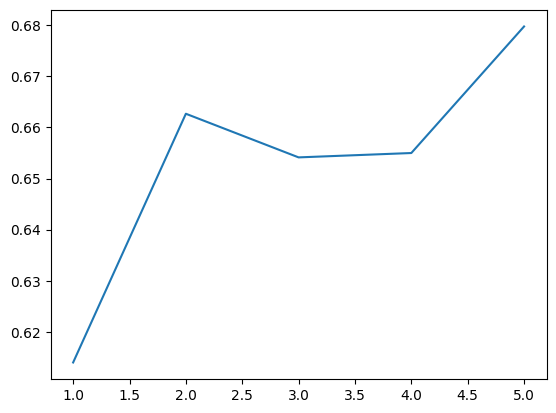

In [9]:
plt.plot(range(1,num_epochs+1),acc_list)

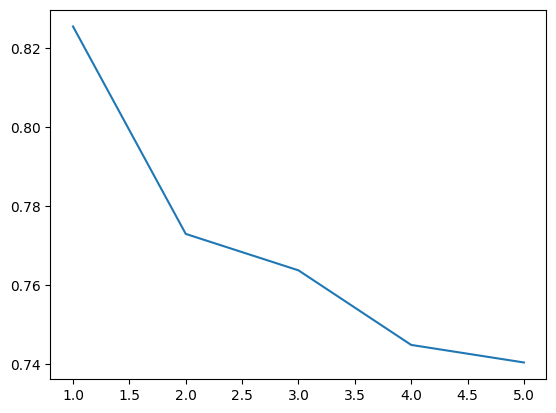

In [10]:
plt.plot(range(1,num_epochs+1),loss_list)